### Single image Pipeline

In [1]:
# Declare required libraries
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip


%matplotlib inline

In [2]:
# function to just find chessboard corners only of an image passed in
def chessboard_corners(img, nx=9, ny=6):
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # create array to store found corners
    image_points = []
    # create intance of image in grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners in the image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found all points for the nx,ny grid size are found - then add them into arrays
    if ret == True:
            # once corners are found increase accuracy of corner position
            corners2 = cv2.cornerSubPix(gray,corners,(5,5),(-1,-1),criteria)
            # append the 2D image points into 2D points array
            #image_points.append(corners2)
            # return found corners in array
            return corners2
    
    


In [3]:
# Function to generate camera calibration and store it in calibration file
# generates the camera matrix, distortion coefficients, rotation and translation vectors
def generate_calibration(img_size, object_points, image_points):

    # calibrate camera image based on 2D points, and fit into 3D array
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img_size, None, None)
    
    # Create pickled calibration file
    # create a variable to hold calibration data
    calibration_parameters = {}
    # add matrix and distortion parameters
    calibration_parameters['mtx'] = mtx
    calibration_parameters['dist'] = dist
    # pickle the calibration data - write bytes
    pickle.dump(calibration_parameters, open('./camera_calibration.p', 'wb'))
    
    # does not return anything as pickled file is output of function

In [4]:
# Function to open pickled calibration data

def get_calibration():
    # Read in the saved camera matrix and distortion coefficients - read bytes
    ret_calib = pickle.load(open('./camera_calibration.p', 'rb'))
    # assign unpickled data to variables
    mtx = ret_calib['mtx']
    dist = ret_calib['dist']
    # return unpickled data - matix & distortion parameters
    return mtx, dist


In [5]:
# Function to correct a passed in image from stored calibration data

def image_correct(img):
    
    # retrieve the camera calibration from a pickled file
    mtx, dist = get_calibration()
    # undistort image with paramters received from calibration
    corrected_image = cv2.undistort(img, mtx, dist, None, mtx)
    # return corrected image
    return corrected_image
    

### Perspective Transform

In [6]:
# Function to get corners into x,y coordinates
def get_coordinates(source):
    x, y = [], []
    
    # loop through passed in array and extraxt data into x, y vectors
    for top in source:
        for mid in top:
            x.append(mid[0])
            y.append(mid[1])
    return x, y

In [7]:
# Function to perform perspective transform - returns a warped image
def perspective_transform(src, dst, corrected_image):

    # get the inverse transform matrix M to transform image back before a warp
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # get the transform matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    
    img_size = (corrected_image.shape[1], corrected_image.shape[0])
    
    # warp image to a top-down view
    warped_image = cv2.warpPerspective(corrected_image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_image, M, M_inv


In [8]:
# function to test the undistort and warp of checkerboard using pickled calibration file and image correction

def corners_unwarp(img):

    # get the camera calibration parameters stored in pickled file
    mtx, dist = get_calibration()
    # use image_correct function to get a correct image using camera stored calibration
    corrected_image = image_correct(img)
    
    # get the corners of the image
    corners = chessboard_corners(corrected_image, 9, 6)
    
    # get 4 exterior corners of the chessboard detection area
    # top-left, top-right, bottom-right, bottom-left
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])

    # get co-ordinates of corners to draw region of interest on image
    # top-left, top-right, bottom-right, bottom-left
    x, y = get_coordinates(src)

    # set 4 destination positions in new image to fit to
    dst = np.float32([[(x[0],y[0]),(x[1],y[0]),(x[1],y[2]),(x[0],y[2])]])

    # add start points to array to draw rectangle in image
    x.append(x[0])
    y.append(y[0])
    # explicitly set figure size
    fig = plt.figure(figsize=(20,10))
    
    title = "Top Left x:{0} y:{1}; \nBottom Right x:{2} y:{3}".format(int(x[0]),int(y[0]),int(x[2]),int(y[2]))
    
    # plot the corners detection rectangle of original image
    plt.subplot(1,3,1)
    plt.plot(x,y,'r')
    plt.axis('off')
    plt.title('Original Image\n' + title, fontsize=15, wrap=True)
    plt.imshow(img)
    
    # plot the corners detection rectangle of corrected image
    plt.subplot(1,3,2)
    plt.plot(x,y,'c')
    plt.axis('off')
    plt.title('Calibrated Image\n' + title, fontsize=15, wrap=True)
    plt.imshow(corrected_image)
    
    # get a warped image from corrected image
    warped, M, M_inv = perspective_transform(src, dst, corrected_image)


    # get co-ordinates of corners to draw region of interest on image
    # top-left, top-right, bottom-right, bottom-left
    # get the coordinates of the corners
    warp_x, warp_y = get_coordinates(dst)
    # add start points to array to draw rectangle in image
    warp_x.append(x[0])
    warp_y.append(y[0])
    
    warp_title = "Top Left x:{0} y:{1}; \nBottom Right x:{2} y:{3}".format(int(warp_x[0]),int(warp_y[0]),int(warp_x[2]),int(warp_y[2]))
    
    # plot the corners detection rectangle of corrected image onto warped image
    plt.subplot(1,3,3)
    plt.plot(warp_x, warp_y, 'b')
    plt.axis('off')
    plt.title('Undistorted and Warped Image\n' + warp_title, fontsize=15, wrap=True)
    plt.imshow(warped, cmap='gray');
        
    # fig save for report - and minimse amout of white space added to saved image
    plt.savefig('./output_images/test_image_correct_warp.png', bbox_inches='tight')
    
    return warped




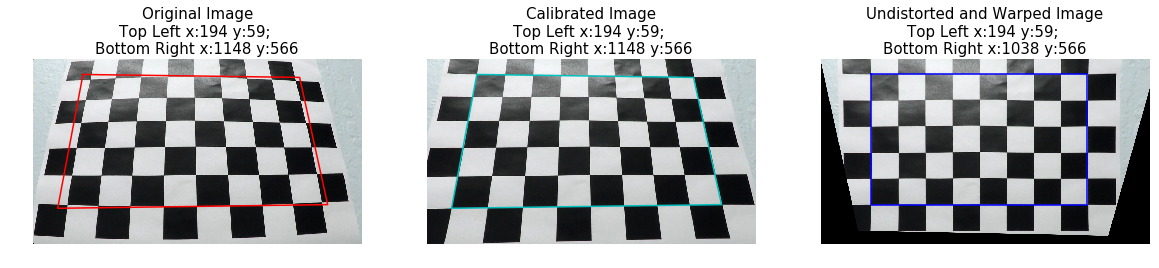

In [9]:
# implementation of test function to display image calibreated and then warped
test_img = cv2.imread('./camera_cal/calibration3.jpg')
nx=9
ny=6
top_down = corners_unwarp(test_img)

In [10]:
# function to undistort and warp road images
def birds_eye_view(img):
    
    img_width, img_height = img.shape[1], img.shape[0]
   
    # set area to distort
    # top left, top-right, bottom-right, bottom-left
    src = np.float32([(img_width/2-65,460),(img_width/2+65,460),(1060,670),(245,670)])
    
    # set destination of warped image
    # top left, top-right, bottom-right, bottom-left
    dst = np.float32([(450,0),(img_width-450,0),(img_width-450,img_height),(450,img_height)])

    # use image_correct function to get a correct image using camera stored calibration
    corrected_image = image_correct(img)
    
    # get a warped image from corrected image
    warped, M, M_inv = perspective_transform(src, dst, corrected_image)
    
    # return a warped image
    return warped, M, M_inv
    

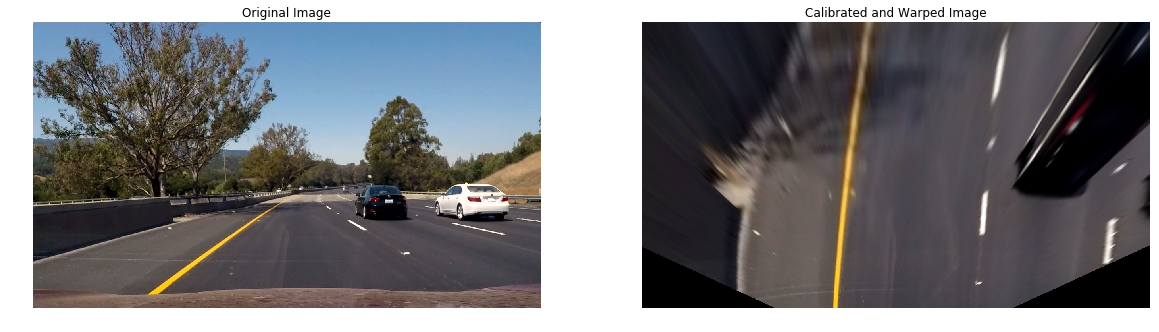

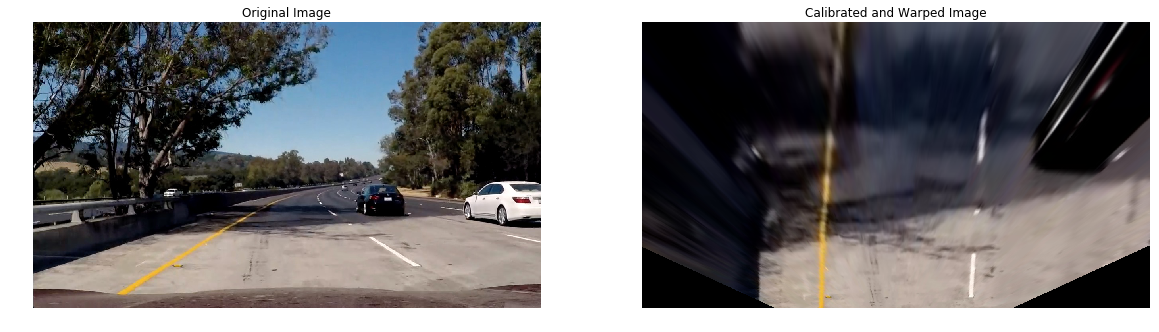

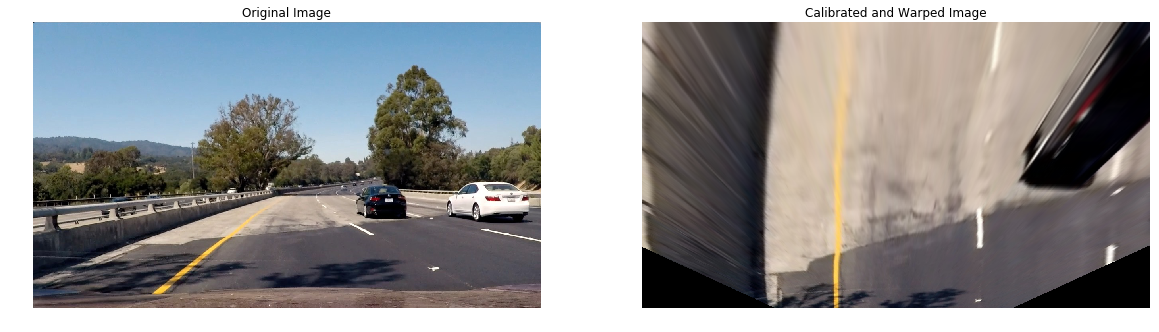

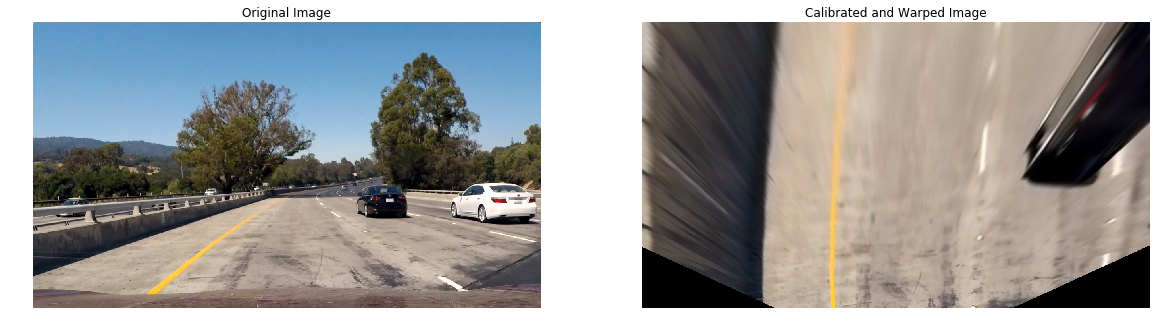

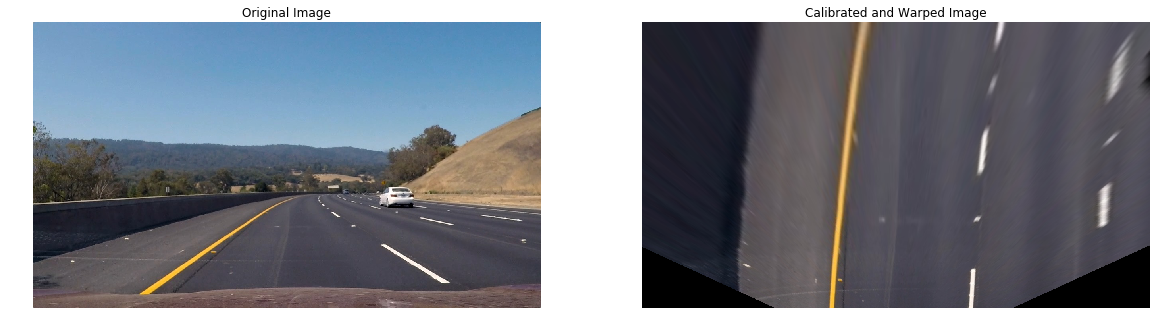

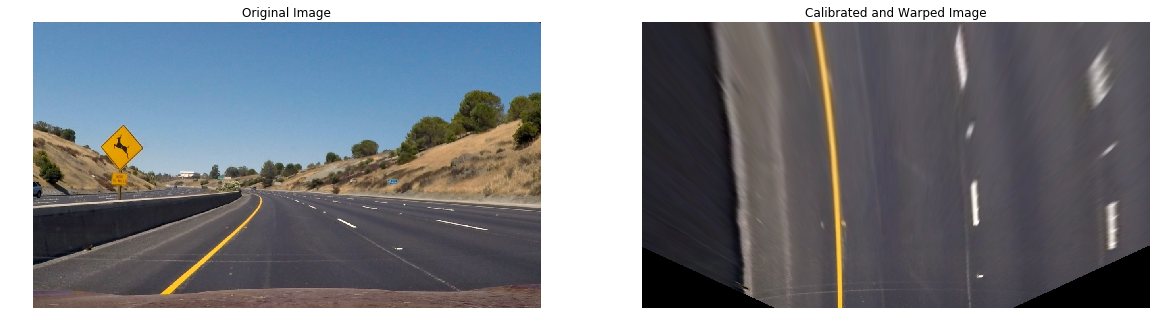

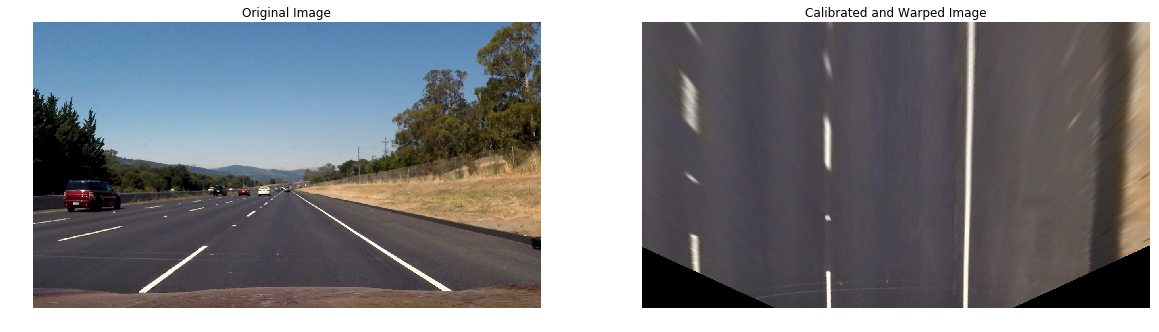

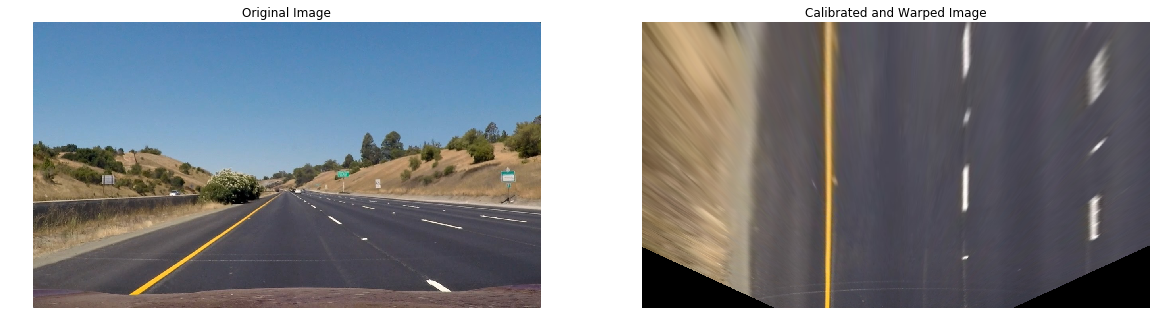

In [11]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

# get the camera calibration parameters stored in pickled file
mtx, dist = get_calibration()


# counter for image file naming
i = 0

for img in images:
    
    # import image
    img = cv2.imread(img)
    
    # change image to RGB for display purpose
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # use image_correct function to get a correct image using camera stored calibration
    corrected_image = image_correct(img)
    
    # use birsdeye function to get warped image
    warped_image, M, M_inv = birds_eye_view(corrected_image)
    
    #create the figure
    fig = plt.figure(figsize=(20,10))

    ax1 = plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    
    ax1 = plt.subplot(1, 2, 2)
    plt.imshow(warped_image)
    plt.axis('off')
    plt.title('Calibrated and Warped Image')
    
    i = i+1
    
    # fig save for report - and minimse amout of white space added to saved image
    plt.savefig('./output_images/warped_corrected_testimages_' + str(i) + '.png', bbox_inches='tight')

    plt.show()

### Warp image and apply colour Threshold

In [12]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=9, thresh=(0, 255)):
    # Calculate directional gradient
    
    #convert image to grayscale ready for sobel
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply cv2.Sobel()
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    # Take the absolute value of the output from cv2.Sobel()
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

In [13]:
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    
    #convert image to grayscale ready for sobel
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply cv2.Sobel() - get x gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # Apply cv2.Sobel() - get x gradient
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    grad_dir = np.absolute(grad_dir)
    # Apply threshold
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return dir_binary

In [14]:
# Image conversion pipeline

def image_conversion_pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100), dir_thresh=(0.7, 1.3)):
    
    img = np.copy(img)
    
    img_height, img_width = img.shape[0], img.shape[1]
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(img, 9 , dir_thresh)
    
    grad_combined = ((sxbinary == 1) & (dir_binary == 1))
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(s_binary), sxbinary, s_binary )) * 255
    
    #combined_binary = np.zeros_like(grad_combined)
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (grad_combined == 1)) ] = 1
    
    # apply the region of interest mask
    # create blank
    mask = np.zeros_like(s_channel)
    # specify polygon shape for region of interest
    roi = np.float32([(img_width/2-85,420),(img_width/2+85,420),(img_width-20,img_height),(20,img_height)])
    # convert roi to numpy array
    roi = np.array(roi, dtype=np.int32)
    
    # fill the region of interest polygon with  colour 1
    cv2.fillPoly(mask, [roi], 1)
    
    # bitwise mask and image to filter image to show only interesting area inside mask
    mask_binary = cv2.bitwise_and(combined_binary, mask)
    
    return mask_binary




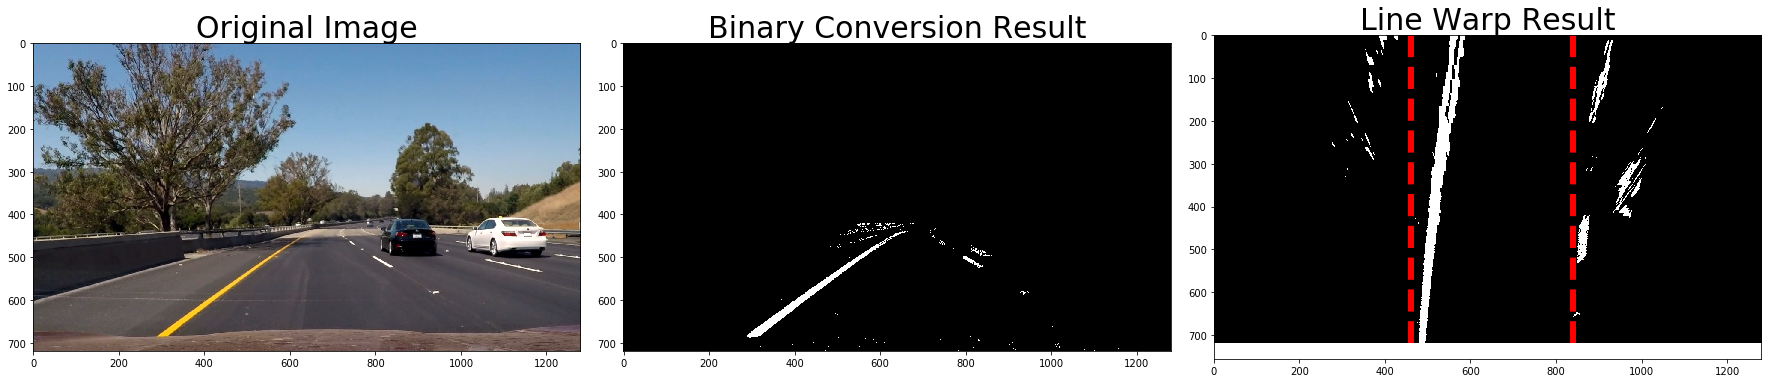

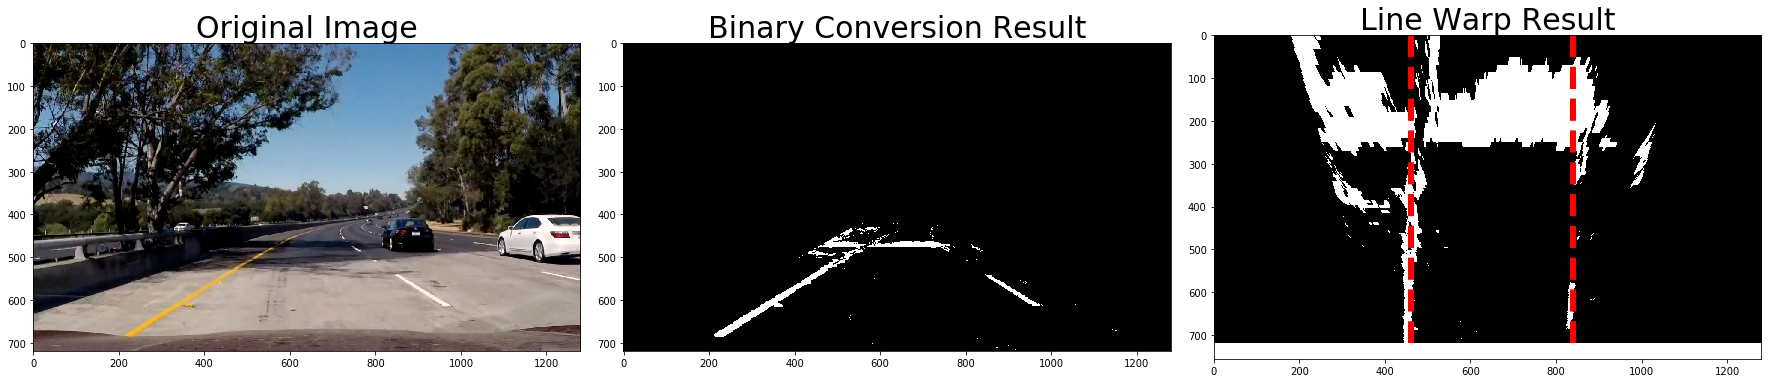

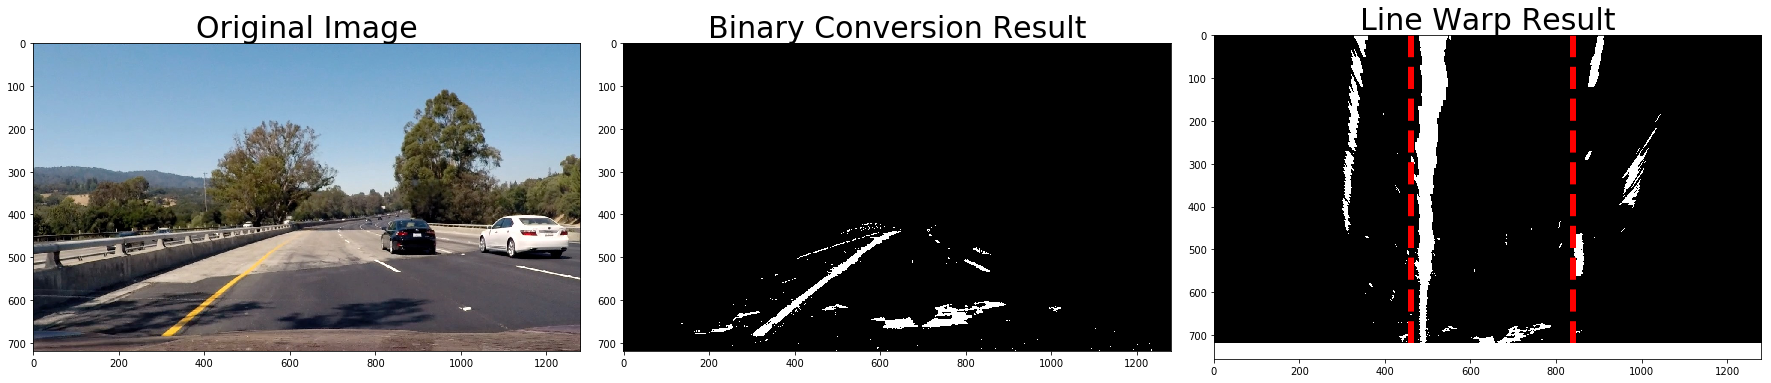

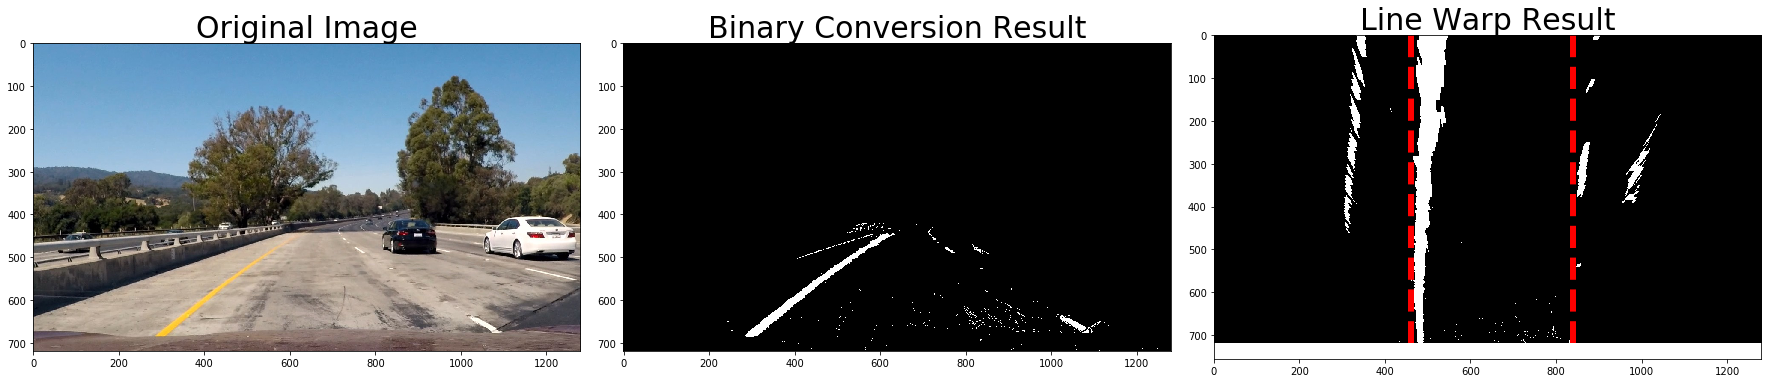

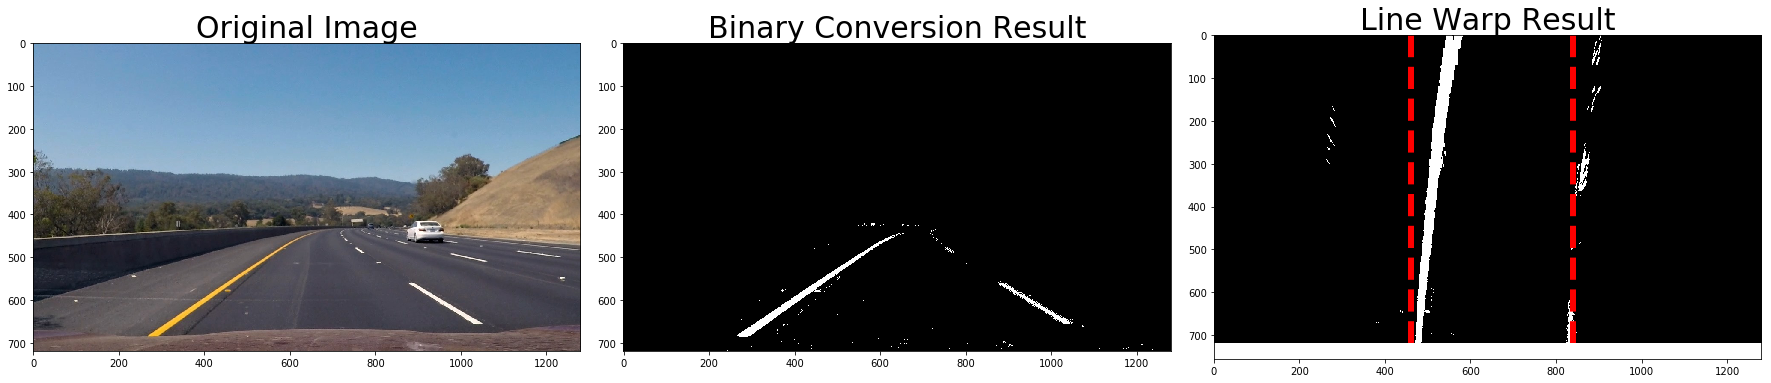

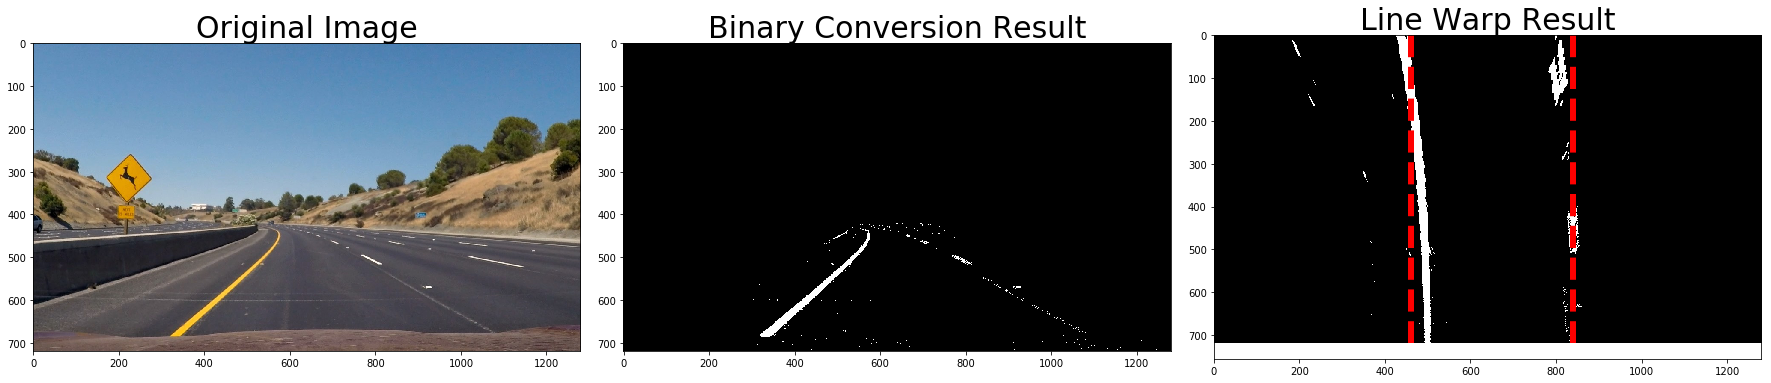

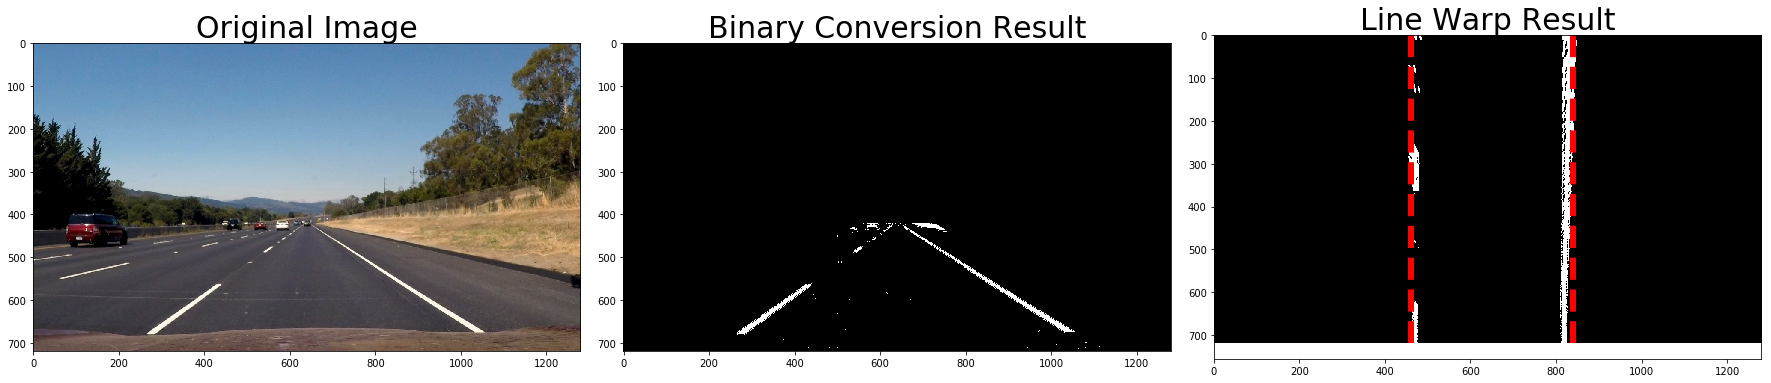

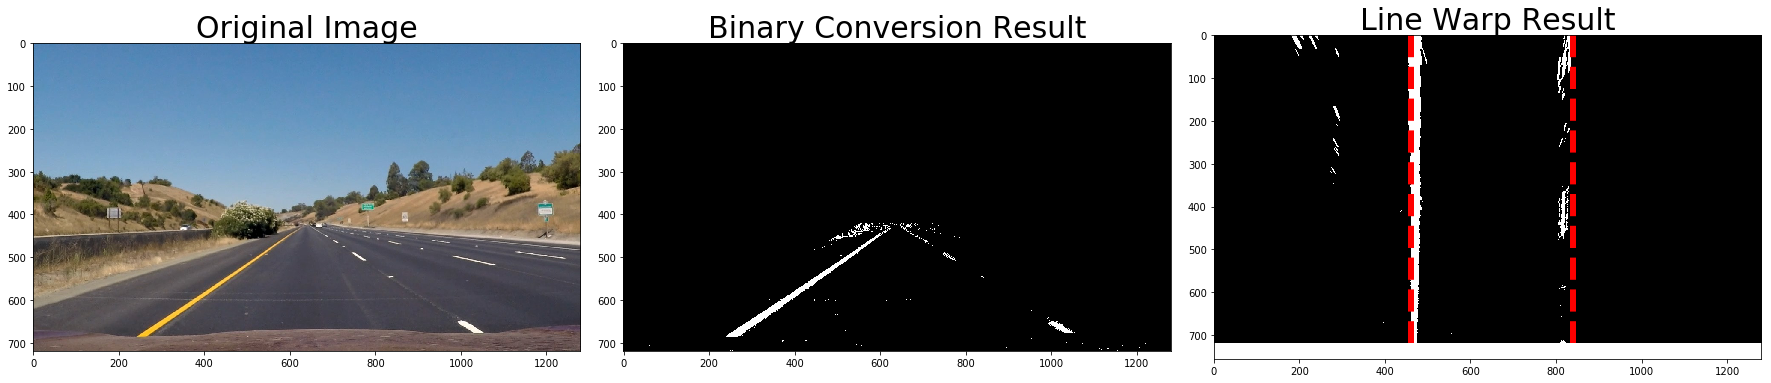

In [15]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

# counter for image file naming
i = 0

for img in images:
    
    # import image
    img = cv2.imread(img)
    
    # change image to RGB for display purpose
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # test image conversion pipeline to output corrected image with only region of interest
    binary = image_conversion_pipeline(img, (90,255), (20,100), (0.7, 1.3))
    
    # warp converted image to get approx. parallel lines
    binary_warped, M, M_inv = birds_eye_view(binary)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)

    ax2.imshow(binary, cmap='gray')
    ax2.set_title('Binary Conversion Result', fontsize=30)

    # warped images, vertical lines added to confirm 'straighness' result - Red lines or not for position
    ax3.imshow(binary_warped, cmap='gray')
    ax3.set_title('Line Warp Result', fontsize=30)

    ax3.plot((460,460),(0,img.shape[0]), 'r--', linewidth=6)
    ax3.plot((840,840),(0,img.shape[0]), 'r--', linewidth=6)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    i = i+1
    
    # fig save for report - and minimse amout of white space added to saved image
    plt.savefig('./output_images/binary_testimages_' + str(i) + '.png', bbox_inches='tight')

    plt.show()

### Histogram

In [16]:

# function to create histogram which detects white lines in a warped image
# split histogram into two sides
def histogram_split(img):
    
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    # sum across image pixels vertically
    # the highest areas of vertical lines should be larger values
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # find peak in left half of histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    # find peak in right half of histogram
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # return the histogram and the left and right detected positions
    return histogram, leftx_base, rightx_base


Histogram detected positions: Left: 493, Right: 838


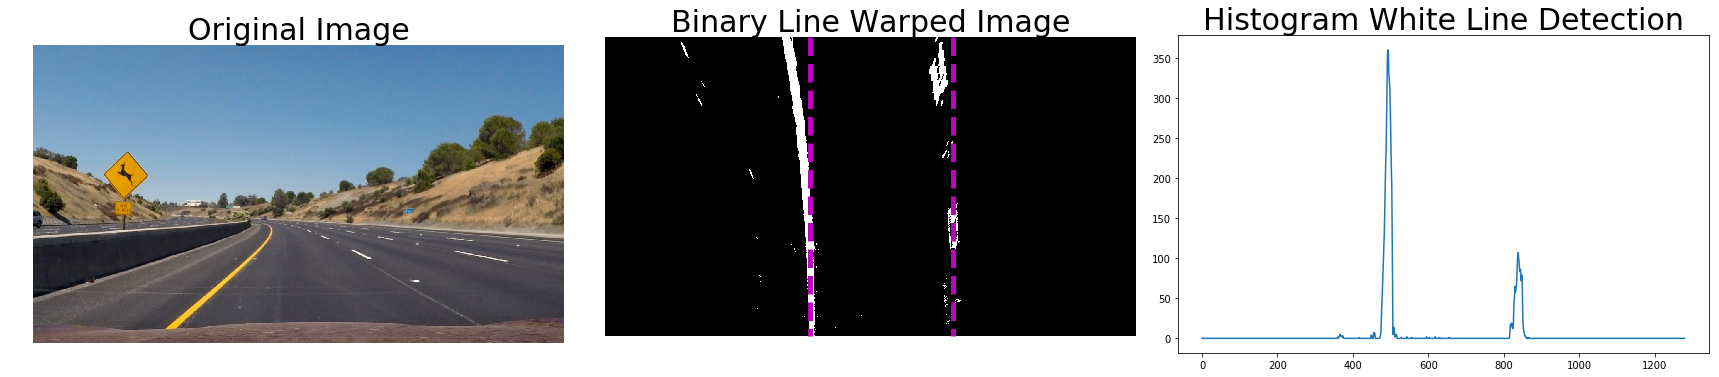

In [17]:
# grab a sigle image to work with from now:
img = mpimg.imread('./test_images/test2.jpg')
# test image conversion pipeline to output corrected image with only region of interest
binary = image_conversion_pipeline(img, (90,255), (20,100), (0.7, 1.3))
# warp converted image to get approx. parallel lines
binary_warped, M, M_inv = birds_eye_view(binary)


# Create histogram of image binary activations
#histogram, start_point_left, start_point_right = hist(final_warped)
histogram, leftx_base, rightx_base = histogram_split(binary_warped)

# confirm lines are approximately correct
print("Histogram detected positions: Left: {0}, Right: {1}".format(leftx_base, rightx_base))

# Plot images and histogram side by side
# display histogram poistions as lines on original image to check performance
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
# Visualise the histogram detected points on warped image
ax2.imshow(binary_warped, cmap='gray')
ax2.plot((leftx_base,leftx_base),(0,img.shape[0]), 'm--', linewidth=5)
ax2.plot((rightx_base,rightx_base),(0,img.shape[0]), 'm--', linewidth=5)
ax2.set_title('Binary Line Warped Image', fontsize=30)
ax2.axis('off')
# Visualize the resulting histogram
ax3.plot(histogram)
ax3.set_title('Histogram White Line Detection', fontsize=30)

# fig save for report - and minimse amout of white space added to saved image
plt.savefig('./output_images/histogram_output.png', bbox_inches='tight')

plt.show()

### Sliding Window Search

In [18]:
# set up the sliding window parameters

# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
# 100 = 200 pixel window width centred around histogram detectect point
margin = 60
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
# 720 / 9 = 80 pixels high
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image

# create arrays to hold the positions of all non-zero pixels in the image
nonzero = binary_warped.nonzero()
# get the y positions of each non-zero pixel in image
nonzeroy = np.array(nonzero[0])
# get the x positions of each non-zero pixel in image
nonzerox = np.array(nonzero[1])
# Current X postion pixel of left lane and right lane from histogram
## to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# array to store the windows as they are made
saved_windows = []


In [19]:
# loop through each of the windows

# Step through number of windows:
    # create window
    
#9 loops as 9 windows is hyper parameter
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    # [0] (y) is image height = 720 pixels
    # window height is 80 pixels
    # 200 x 80 boxes are drawn
    
    # find top of window, but at bottom of image
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    # find bottom of window, but at bottom of image
    win_y_high = binary_warped.shape[0] - window*window_height
    # left side of left window
    win_xleft_low = leftx_current - margin
    # rigth side of right window
    win_xleft_high = leftx_current + margin
    # left side of right window
    win_xright_low = rightx_current - margin
    # right side of right window
    win_xright_high = rightx_current + margin
    
    saved_windows.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
    
    # Identify the nonzero pixels in x and y within the window #
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # re-centre current position to best position at top of window based on mean of pixels
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        #print(leftx_current)
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        #print(rightx_current)
        
# Concatenate the arrays of indices (previously was a list of lists of pixels)
try:
    left_lane_inds_cat = np.concatenate(left_lane_inds)
    right_lane_inds_cat = np.concatenate(right_lane_inds)
except ValueError:
    # Avoids an error if the above is not implemented fully
    pass

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds_cat]
lefty = nonzeroy[left_lane_inds_cat] 
rightx = nonzerox[right_lane_inds_cat]
righty = nonzeroy[right_lane_inds_cat]




In [20]:
# fit a polyline to the points collected

# Fit a second order polynomial to each using `np.polyfit`
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print(left_fit)

[-1.23561317e-04  1.71422836e-01  4.38106922e+02]


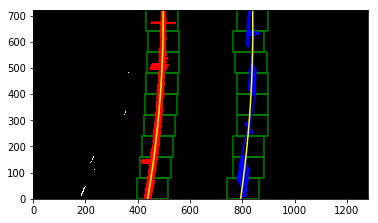

In [21]:
# create a pixel array same size as image height
# start point = 0, stop point = 720-1, number of points = 720
# Returns evenly spaced numbers over a specified interval

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# stack image arrays along 3rd axis - create image like rgb dimensions
# image goes from (720, 1280) > (720, 1280,3)
###### plot_out_img = np.dstack((final_warped,final_warped,final_warped))

# generate x and y positions in the image to draw lines
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



# limit the plot dimensions to the image size
plt.xlim(0, 1280)
plt.ylim(0,720)

# draw the sliding windows onto the plot
for window in saved_windows:
    rectangle = plt.Rectangle((window[2],window[1]), margin*2, -window_height, ec='g', fill=None, linewidth = 1.5)
    plt.gca().add_patch(rectangle)
    rectangle = plt.Rectangle((window[4],window[1]), margin*2, -window_height, ec='g', fill=None, linewidth = 1.5)
    plt.gca().add_patch(rectangle)
    
# plot the pixels being conisdered for line fitting
plt.plot(leftx,lefty, 'r') # red for left line pixels
plt.plot(rightx,righty, 'b') # blue for right line pixels

# Plot the left and right polynomial reuslt ot show the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

# show the warped binary - pixels excluded from line fit can be seen in white
plt.imshow(binary_warped, cmap='gray')

# fig save for report - and minimse amout of white space added to saved image
plt.savefig('./output_images/sliding_window.png', bbox_inches='tight')

plt.show()

### Skipping Sliding Window if lines are already known

In [22]:
print(left_fit)
print(right_fit)

# search around previous polyline for conintuation of line

# margin width - area to search for polyline
search_margin = 60

# Grab activated pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                right_fit[1]*nonzeroy + right_fit[2] + margin)))


# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

  

[-1.23561317e-04  1.71422836e-01  4.38106922e+02]
[-1.11191222e-04  1.43867263e-01  7.93522430e+02]


In [23]:
# fit a polyline to the new points collected

# Fit a second order polynomial to each using `np.polyfit`
left_fit_next = np.polyfit(lefty, leftx, 2)
right_fit_next = np.polyfit(righty, rightx, 2)

print(left_fit_next)

[-1.23098157e-04  1.71172980e-01  4.38127750e+02]


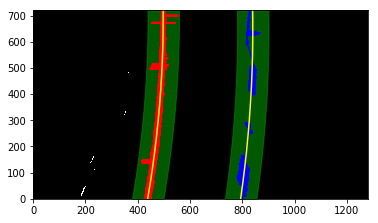

In [24]:
# create a pixel array same size as image height
# start point = 0, stop point = 720-1, number of points = 720
# Returns evenly spaced numbers over a specified interval

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# stack image arrays along 3rd axis - create image like rgb dimensions
# image goes from (720, 1280) > (720, 1280,3)
###### plot_out_img = np.dstack((final_warped,final_warped,final_warped))

# generate x and y positions in the image to draw lines
left_fit_nextx = left_fit_next[0]*ploty**2 + left_fit_next[1]*ploty + left_fit_next[2]
right_fit_nextx = right_fit_next[0]*ploty**2 + right_fit_next[1]*ploty + right_fit_next[2]

left_poly_lower = [x - search_margin for x in left_fit_nextx]
left_poly_upper = [x + search_margin for x in left_fit_nextx]
right_poly_lower = [x - search_margin for x in right_fit_nextx]
right_poly_upper = [x + search_margin for x in right_fit_nextx]

# limit the plot dimensions to the image size
plt.xlim(0, 1280)
plt.ylim(0,720)
    
# plot the pixels being conisdered for line fitting
plt.plot(leftx,lefty, 'r') # red for left line pixels
plt.plot(rightx,righty, 'b') # blue for right line pixels

# Plot the left and right polynomial reuslt ot show the lane lines
plt.plot(left_fit_nextx, ploty, color='yellow')
plt.plot(right_fit_nextx, ploty, color='yellow')

# plot fills to indicate the total search area for left and right lines
plt.fill_betweenx(ploty, left_poly_lower, left_poly_upper, color='g', alpha=0.7)
plt.fill_betweenx(ploty, right_poly_lower, right_poly_upper, color='g', alpha=0.7)

# show the warped binary - pixels excluded from line fit can be seen in white
plt.imshow(binary_warped, cmap='gray')

# fig save for report - and minimse amout of white space added to saved image
plt.savefig('./output_images/previous_search_output.png', bbox_inches='tight')

plt.show()

### real world curvature

Left Curvature Radius in pixels: 4062.0p
Left Curvature Radius in metres: 677.3m
Right Curvature Radius in pixels: 4498.5p
Right Curvature Radius in metres: 749.9m


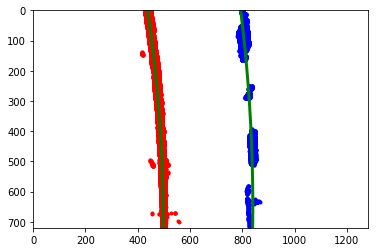

In [25]:
  
y_eval = np.max(ploty)
# reverse array to match top to bottom in Y
left_nextx = leftx# [::-1]
right_nextx = rightx# [::-1]    

# create a poly lines of the array of points
# create left line 2nd order polynominal for calculations
left_fit_next = np.polyfit(lefty, left_nextx, 2)
# create polyline for plotting
left_fit_nextx = left_fit_next[0]*ploty**2 + left_fit_next[1]*ploty + left_fit_next[2]
# create right line 2nd order polynominal for calculations
right_fit_next = np.polyfit(righty, right_nextx, 2)
# create polyline for plotting
right_fit_nextx = right_fit_next[0]*ploty**2 + right_fit_next[1]*ploty + right_fit_next[2]


# rural highways in US(std broken line): 3m line, 7m gap
# mask area is 3 lines + 3 gaps, so as image is y = 720 pixels; 
# 30m/720pixels gives 0.0416m/pixel in y
# lane width is 3.7m, lane width in pixels is:
# right_fit_nextx[0] - left_fit_nextx[0]
lane_width = right_fit_nextx[0] - left_fit_nextx[0]
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/lane_width # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters

img_size = binary_warped.shape

# Calculate offset of car
camera_centre = (left_fitx[-1] + right_fitx[-1]) / 2
centre_diff = (camera_centre - img_size[1] / 2) * xm_per_pix
side_pos = 'left'
if centre_diff <= 0:
    side_pos = 'right'

# get curvature in pixel
left_curverad_pix = ((1 + (2*left_fit_next[0]*y_eval + left_fit_next[1])**2)**1.5) / np.absolute(2*left_fit_next[0])
right_curverad_pix = ((1 + (2*right_fit_next[0]*y_eval + right_fit_next[1])**2)**1.5) / np.absolute(2*right_fit_next[0])

# create polyline in metres
left_fit_cr = np.polyfit(lefty*ym_per_pix, left_nextx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, right_nextx*xm_per_pix, 2)

# calculate curves to get radius of curvature
left_curverad_real = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad_real = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    

#print(y_eval)
print("Left Curvature Radius in pixels: {0:.1f}p".format(left_curverad_pix))
print("Left Curvature Radius in metres: {0:.1f}m".format(left_curverad_real))
print("Right Curvature Radius in pixels: {0:.1f}p".format(right_curverad_pix))
print("Right Curvature Radius in metres: {0:.1f}m".format(right_curverad_real))


# Plot data
mark_size = 3
plt.plot(left_nextx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(right_nextx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fit_nextx, ploty, color='green', linewidth=3)
plt.plot(right_fit_nextx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [26]:
def draw_lane_lines(img, binary_img, left_fit, right_fit, M_inv):
    
    img_copy = np.copy(img)
    
    # Create an image to draw the lines on
    # create a blank array same size as binary image
    zero_blank = np.zeros_like(binary_img).astype(np.uint8)
    # Stack blank into 3 channels
    coloured_blank = np.dstack((zero_blank, zero_blank, zero_blank))
    
    # set variables from image size
    image_height, image_width = binary_img.shape
    
    # Return evenly spaced numbers over specified interval - height of image
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    
    # create line of points from polynominal
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # covert to array for cv.poly functions
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    inner_lane = np.hstack((left_line_window, right_line_window))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(coloured_blank, np.int_([inner_lane]), (0,255, 0))
    cv2.polylines(coloured_blank, np.int32([left_line_window]), isClosed=False, color=(255,0,0), thickness=20)
    cv2.polylines(coloured_blank, np.int32([right_line_window]), isClosed=False, color=(0,0,255), thickness=20)

    # Warp the blank with annotated lines back to original image space using inverse perspective matrix (Minv)
    undistort = cv2.warpPerspective(coloured_blank, M_inv, (image_width, image_height))
    # Combine the result with the original image
    output_img = cv2.addWeighted(img_copy, 1, undistort, 1.0, 0)
    
    # add text to image to display curvature and vehicle offset information
    cv2.putText(output_img, 'Left Lane Curvature Radius: {:.2f}m'.format(left_curverad_real), 
                (int(img.shape[0]/6), 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 3)
    cv2.putText(output_img, 'Vehicle is: {0:.2f}m {1} of centre'.format(centre_diff, side_pos), 
                (int(img.shape[0]/6), 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 3)
    
    # return a full colour image with the hightlighted image painted onto image
    return output_img

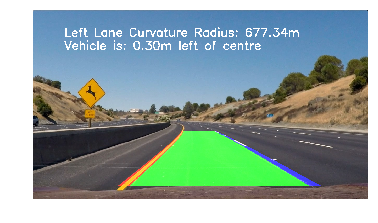

In [27]:
to_plot = draw_lane_lines(img,binary_warped,left_fit_next,right_fit_next,M_inv)

plt.imshow(to_plot)

# fig save for report - and minimse amout of white space added to saved image
plt.savefig('./output_images/annotated_lane.png', bbox_inches='tight')
plt.axis('Off')
plt.show()